In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torchvision
import os
import torch.nn.functional as F

In [29]:
import argparse
parser = argparse.ArgumentParser(description='Membership inference Attacks on Network Pruning')
parser.add_argument('--device', default=3, type=int, help="GPU id to use")
parser.add_argument('--config_path', default=0, type=str, help="config file path")
parser.add_argument('--dataset_name', default='mnist', type=str)
parser.add_argument('--model_name', default='mnist', type=str)
parser.add_argument('--num_cls', default=10, type=int)
parser.add_argument('--input_dim', default=1, type=int)
parser.add_argument('--image_size', default=28, type=int)
parser.add_argument('--hidden_size', default=128, type=int)
parser.add_argument('--seed', default=7, type=int)
parser.add_argument('--early_stop', default=5, type=int)
parser.add_argument('--batch_size', default=128, type=int)
parser.add_argument('--prune_epochs', default=50, type=int)
parser.add_argument('--pruner_name', default='l1unstructure', type=str, help="prune method for victim model")
parser.add_argument('--prune_sparsity', default=0.5, type=float, help="prune sparsity for victim model")
parser.add_argument('--adaptive', action='store_true', help="use adaptive attack")
parser.add_argument('--shadow_num', default=5, type=int)
parser.add_argument('--defend', default='', type=str)
parser.add_argument('--defend_arg', default=4, type=float)
parser.add_argument('--attacks', default="samia", type=str)
parser.add_argument('--original', action='store_true', help="original=true, then launch attack against original model")

# PROGRAM level args
parser.add_argument("--data_dir", type=str, default="/data/huy/cifar10")
parser.add_argument("--download_weights", type=int, default=0, choices=[0, 1])
parser.add_argument("--test_phase", type=int, default=1, choices=[0, 1])
parser.add_argument("--dev", type=int, default=0, choices=[0, 1])
parser.add_argument(
    "--logger", type=str, default="wandb", choices=["tensorboard", "wandb"]
)
parser.add_argument("--pruned_weights", type=str, default="resnet18_pruned_model_1.pt")

# TRAINER args
parser.add_argument("--classifier", type=str, default="resnet18")
parser.add_argument("--pretrained", type=int, default=0, choices=[0, 1])

parser.add_argument("--precision", type=int, default=32, choices=[16, 32])
parser.add_argument("--max_epochs", type=int, default=100)
parser.add_argument("--num_workers", type=int, default=8)
parser.add_argument("--gpu_id", type=str, default="3")

parser.add_argument("--learning_rate", type=float, default=1e-2)
parser.add_argument("--weight_decay", type=float, default=1e-2)
args1 = {
    "data_dir": "/data/huy/cifar10",
    "download_weights": 0,
    "test_phase": 1,
    "dev": 0,
    "logger": "wandb",
    "classifier": "resnet18",
    "pretrained": 0,
    "precision": 32,
    "max_epochs": 100,
    "num_workers": 8,
    "gpu_id": 3,
    "learning_rate": 1e-2,
    "weight_decay": 1e-2,
    "dataset_name": "cifar10",
    "model_name": "resnet18",
    "epochs": 100,
    "num_cls": 10,
    "input_dim": 3,
    "optimizer": "adam",
    "lr": 0.001,
    "weight_decay": 5e-4,
    "batch_size": 128,
}
class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)
args = Struct(**args1)

In [30]:
import json
import numpy as np
import pickle
import random
import torch
import torch.backends.cudnn as cudnn
from torch.utils.data import ConcatDataset, DataLoader, Subset
from base_model import BaseModel
from datasets import get_dataset
from module import CIFAR10Module

device = f"cuda"
dataset_name = "cifar10"
model_name = "resnet18"
input_dim = 3
batch_size = 128
num_cls = 10
pruner_name = "l1unstructure"
prune_sparsity = 0.5
shadow_model_num = 1
prune_sparsity = 0.5
num_epochs = 40
model_dir="saved_models_afterprune"

pruned_model_filename = f"{args.classifier}_pruned_{prune_sparsity}_{num_epochs}.pt"
pruned_model_filepath = os.path.join(model_dir, pruned_model_filename)
print(f"Generating model: {pruned_model_filepath}")
print(f"Pruning sparsity: {prune_sparsity} Number of epochs: {num_epochs}")
victim_model = CIFAR10Module(args1)
# data = CIFAR10Data(args)
state_dict = os.path.join(
    "cifar10_models", "state_dicts", args.classifier + ".pt"
)
victim_model.model.load_state_dict(torch.load(state_dict))
victim_model.model.to(device)
victim_model.model.eval()
    
victim_pruned_model = CIFAR10Module(args1)
victim_pruned_model.load_state_dict(torch.load(pruned_model_filepath))
victim_pruned_model.model.to(device)
victim_pruned_model.model.eval()

Generating model: saved_models_afterprune/resnet18_pruned_0.5_40.pt
Pruning sparsity: 0.5 Number of epochs: 40


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
def predict_target_sensitivity(self, data_loader, m=10, epsilon=1e-3):
    self.model.eval()
    predict_list = []
    sensitivity_list = []
    target_list = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            outputs = self.model(inputs)
            predicts = F.softmax(outputs, dim=-1)
            predict_list.append(predicts.detach().data.cpu())
            target_list.append(targets.detach().data.cpu())

            if len(inputs.size()) == 4:
                x = inputs.repeat((m, 1, 1, 1))
            elif len(inputs.size()) == 3:
                x = inputs.repeat((m, 1, 1))
            elif len(inputs.size()) == 2:
                x = inputs.repeat((m, 1))
            u = torch.randn_like(x)
            evaluation_points = x + epsilon * u
            new_predicts = F.softmax(self.model(evaluation_points), dim=-1)
            diff = torch.abs(new_predicts - predicts.repeat((m, 1)))
            diff = diff.view(m, -1, num_cls)
            sensitivity = diff.mean(dim=0) / epsilon
            sensitivity_list.append(sensitivity.detach().data.cpu())

    targets = torch.cat(target_list, dim=0)
    predicts = torch.cat(predict_list, dim=0)
    sensitivities = torch.cat(sensitivity_list, dim=0)
    return predicts, targets, sensitivities


In [32]:
trainset = get_dataset(args.dataset_name, train=True)
testset = get_dataset(args.dataset_name, train=False)
# if testset is None:
#     total_dataset = trainset
# else:
#     total_dataset = ConcatDataset([trainset, testset])
total_dataset = testset
total_size = len(total_dataset)
victim_train_dataset = Subset(trainset, np.random.choice(len(trainset), 10000, replace=False))
victim_test_dataset = testset
print(f"Total Data Size: {total_size}, "
        f"Victim Train Size: {len(trainset)}, "
        f"Victim Test Size: {len(testset)}")
victim_train_loader = DataLoader(victim_train_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4,
                                    pin_memory=False)
victim_test_loader = DataLoader(victim_test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4,
                                pin_memory=False)

Build Dataset cifar10
Files already downloaded and verified
Build Dataset cifar10
Files already downloaded and verified
Total Data Size: 10000, Victim Train Size: 50000, Victim Test Size: 10000


In [33]:
small_victim_in_predicts, victim_in_targets, small_victim_in_sens = predict_target_sensitivity(victim_pruned_model, victim_train_loader)
small_victim_out_predicts, victim_out_targets, small_victim_out_sens = predict_target_sensitivity(victim_pruned_model, victim_test_loader)
big_victim_in_predicts, _, big_victim_in_sens = predict_target_sensitivity(victim_model, victim_train_loader)
big_victim_out_predicts, _, big_victim_out_sens = predict_target_sensitivity(victim_model, victim_test_loader)

# Original Model Confidence

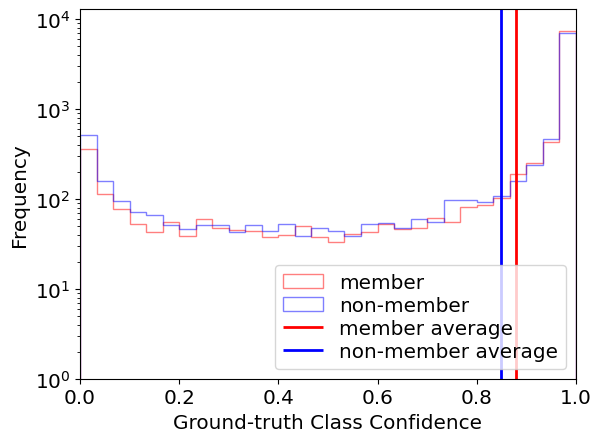

In [34]:
data_in = big_victim_in_predicts[np.arange(len(victim_in_targets)), victim_in_targets].numpy()
data_out = big_victim_out_predicts[np.arange(len(victim_out_targets)), victim_out_targets].numpy()
plt.hist(data_in, alpha=0.5, bins=30, log=True, label='member', color='r', histtype=u'step')
plt.hist(data_out, alpha=0.5, bins=30, log=True, label='non-member', color='b', histtype=u'step')
plt.vlines(np.mean(data_in), 0, 13000, colors='r', linewidth=2, label='member average')
plt.vlines(np.mean(data_out), 0, 13000, colors='b', linewidth=2, label='non-member average')

plt.xlabel("Ground-truth Class Confidence", fontsize='x-large')
plt.ylabel("Frequency", fontsize='x-large')
plt.xlim([0, 1.0])
plt.ylim([1, 13000])
plt.legend(fontsize='x-large', labelspacing=0.2, loc='lower right')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.show()

# Pruned Model Confidence

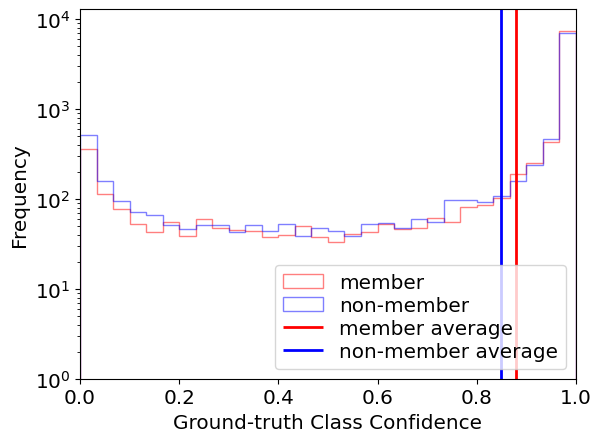

In [35]:
data_in = small_victim_in_predicts[np.arange(len(victim_in_targets)), victim_in_targets].numpy()
data_out = small_victim_out_predicts[np.arange(len(victim_out_targets)), victim_out_targets].numpy()
plt.hist(data_in, alpha=0.5, bins=30, log=True, label='member', color='r', histtype=u'step')
plt.hist(data_out, alpha=0.5, bins=30, log=True, label='non-member', color='b', histtype=u'step')

plt.vlines(np.mean(data_in), 0, 13000, colors='r', linewidth=2, label='member average')
plt.vlines(np.mean(data_out), 0, 13000, colors='b', linewidth=2, label='non-member average')

plt.xlabel("Ground-truth Class Confidence", fontsize='x-large')
plt.ylabel("Frequency", fontsize='x-large')
plt.xlim([0, 1.0])
plt.ylim([1, 13000])
plt.legend(fontsize='x-large', labelspacing=0.2, loc='lower right')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.show()

# Original Model Sensitivity

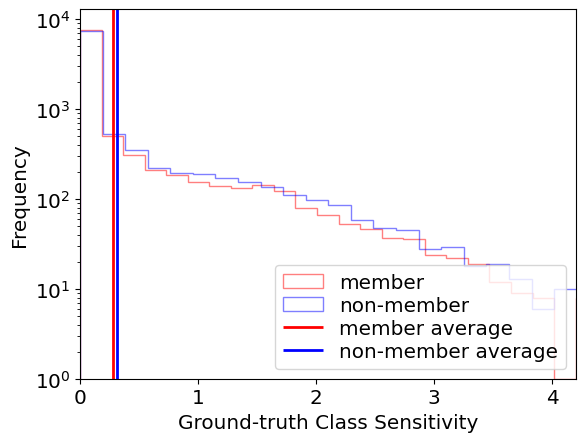

In [36]:
data_in = big_victim_in_sens[np.arange(len(victim_in_targets)), victim_in_targets].numpy()
data_out = big_victim_out_sens[np.arange(len(victim_out_targets)), victim_out_targets].numpy()
plt.hist(data_in, alpha=0.5, bins=30, log=True, label='member', color='r', histtype=u'step')
plt.hist(data_out, alpha=0.5, bins=30, log=True, label='non-member', color='b', histtype=u'step')

plt.vlines(np.mean(data_in), 0, 13000, colors='r', linewidth=2, label='member average')
plt.vlines(np.mean(data_out), 0, 13000, colors='b', linewidth=2, label='non-member average')

plt.xlabel("Ground-truth Class Sensitivity", fontsize='x-large')
plt.ylabel("Frequency", fontsize='x-large')
# plt.autoscale(tight=True)
plt.xlim([0, 4.2])
plt.ylim([1, 13000])
plt.legend(fontsize='x-large', labelspacing=0.2, loc='lower right')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.show()

# Pruned Model Sensitivity

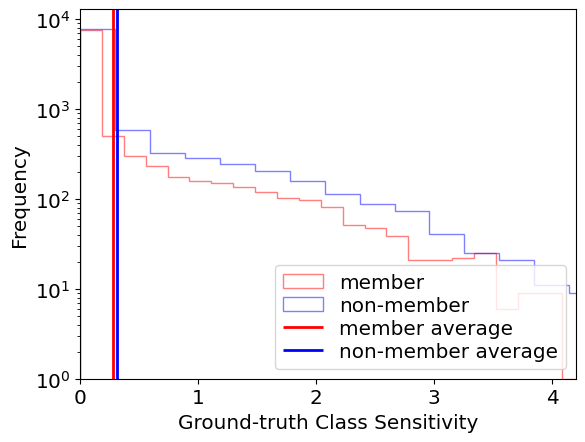

In [37]:
data_in = small_victim_in_sens[np.arange(len(victim_in_targets)), victim_in_targets].numpy()
data_out = small_victim_out_sens[np.arange(len(victim_out_targets)), victim_out_targets].numpy()
plt.hist(data_in, alpha=0.5, bins=30, log=True, label='member', color='r', histtype=u'step')
plt.hist(data_out, alpha=0.5, bins=30, log=True, label='non-member', color='b', histtype=u'step')

plt.vlines(np.mean(data_in), 0, 13000, colors='r', linewidth=2, label='member average')
plt.vlines(np.mean(data_out), 0, 13000, colors='b', linewidth=2, label='non-member average')

plt.xlabel("Ground-truth Class Sensitivity", fontsize='x-large')
plt.ylabel("Frequency", fontsize='x-large')
# plt.autoscale(tight=True)
plt.xlim([0, 4.2])
plt.ylim([1, 13000])
plt.legend(fontsize='x-large', labelspacing=0.2, loc='lower right')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.show()

In [38]:
def prec2(predicts, targets):
    a = [[] for _ in range(num_cls)]
    for i in range(predicts.size(0)):
        a[targets[i]].append(predicts[i, targets[i]])
    b = [np.mean(x) for x in a]
    return np.array(b)

data1 = prec2(big_victim_in_predicts, victim_in_targets)
data2 = prec2(big_victim_out_predicts, victim_out_targets)
data3 = prec2(small_victim_in_predicts, victim_in_targets)
data4 = prec2(small_victim_out_predicts, victim_out_targets)

# Original model confidence over different classes

Files already downloaded and verified


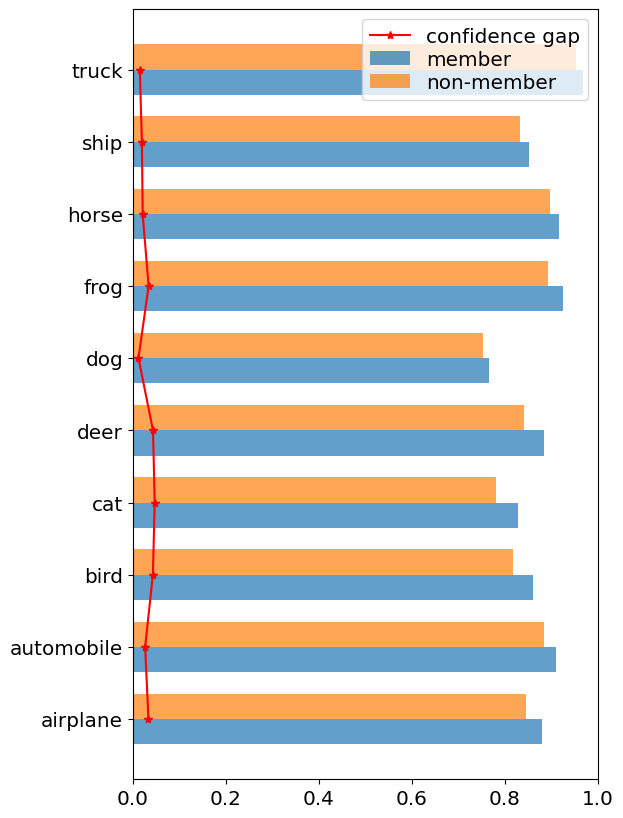

In [39]:
width = 0.35
new_indices = np.arange(10)
tmp1_new = data1[new_indices]
tmp2_new = data2[new_indices]

dataset = torchvision.datasets.CIFAR10(root='data/datasets/cifar10-data', train=False, download=True)
labels = np.arange(len(new_indices))
classes = dataset.classes
plt.figure(figsize=(6,10))
plt.barh(labels-width/2, tmp1_new, width, alpha=0.7, label="member")
plt.barh(labels+width/2, tmp2_new, width, alpha=0.7, label="non-member")
plt.plot(tmp1_new - tmp2_new, labels, '*-', c='r', label="confidence gap")
plt.yticks(labels, labels=[classes[x].replace("_", " ") for x in new_indices], fontsize='x-large')
plt.legend(fontsize='x-large', labelspacing=0.2)
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.xlim([0,1])
plt.show()

# Pruned model confidence over different classes

Files already downloaded and verified


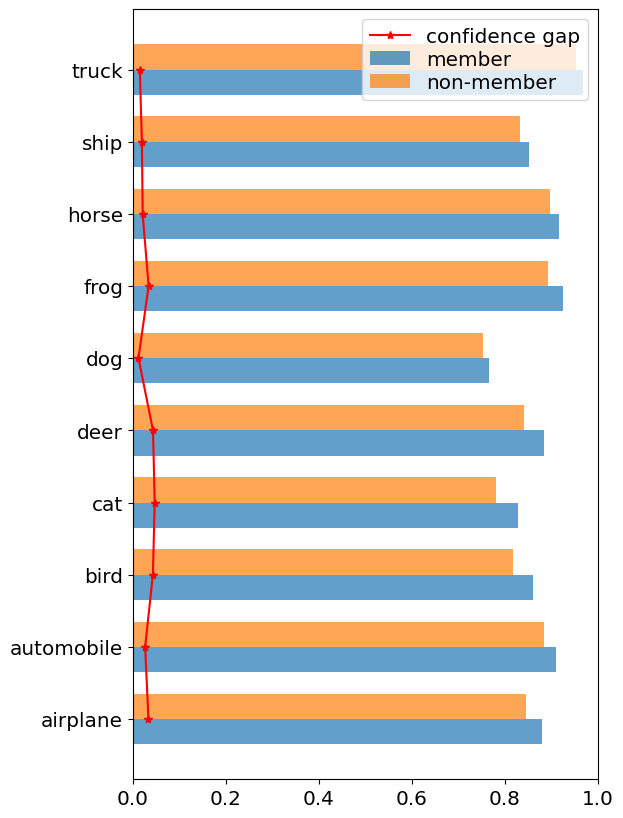

In [40]:
width = 0.35
new_indices = np.arange(10)
tmp1_new = data3[new_indices]
tmp2_new = data4[new_indices]

dataset = torchvision.datasets.CIFAR10(root='data/datasets/cifar10-data', train=False, download=True)
labels = np.arange(len(new_indices))
classes = dataset.classes
plt.figure(figsize=(6,10))
plt.barh(labels-width/2, tmp1_new, width, alpha=0.7, label="member")
plt.barh(labels+width/2, tmp2_new, width, alpha=0.7, label="non-member")
plt.plot(tmp1_new - tmp2_new, labels, '*-', c='r', label="confidence gap")
plt.yticks(labels, labels=[classes[x].replace("_", " ") for x in new_indices], fontsize='x-large')
plt.legend(fontsize='x-large', labelspacing=0.2)
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.xlim([0,1])
plt.show()

In [41]:
data1 = prec2(big_victim_in_sens, victim_in_targets)
data2 = prec2(big_victim_out_sens, victim_out_targets)
data3 = prec2(small_victim_in_sens, victim_in_targets)
data4 = prec2(small_victim_out_sens, victim_out_targets)

# Original Model Sensitivity over different classes

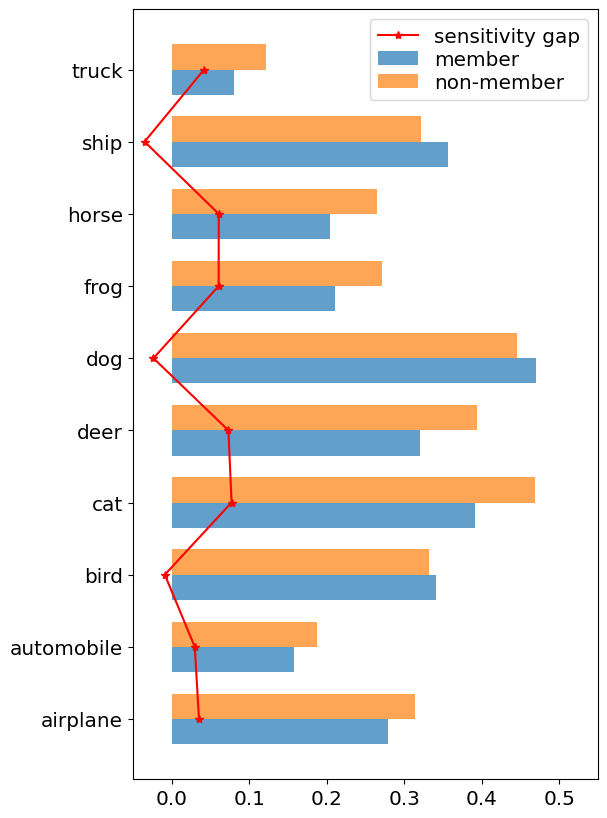

In [42]:
width = 0.35
new_indices = np.arange(10)
tmp1_new = data1[new_indices]
tmp2_new = data2[new_indices]

dataset = torchvision.datasets.CIFAR10(root='data/datasets/cifar10-data', train=False, download=False)
labels = np.arange(len(new_indices))
classes = dataset.classes
plt.figure(figsize=(6,10))
plt.barh(labels-width/2, tmp1_new, width, alpha=0.7, label="member")
plt.barh(labels+width/2, tmp2_new, width, alpha=0.7, label="non-member")
plt.plot(tmp2_new - tmp1_new, labels, '*-', c='r', label="sensitivity gap")
plt.yticks(labels, labels=[classes[x].replace("_", " ") for x in new_indices], fontsize='x-large')
plt.legend(fontsize='x-large', labelspacing=0.2)
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.xlim([-0.05,0.55])
plt.show()

# Pruned Model Sensitivity over different classes

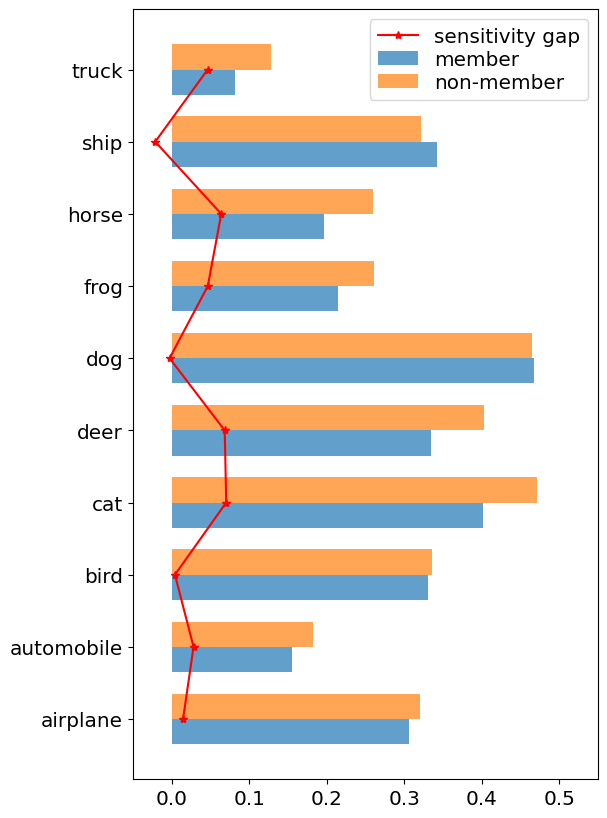

In [43]:
width = 0.35
new_indices = np.arange(10)
tmp1_new = data3[new_indices]
tmp2_new = data4[new_indices]

dataset = torchvision.datasets.CIFAR10(root='data/datasets/cifar10-data', train=False, download=False)
labels = np.arange(len(new_indices))
classes = dataset.classes
plt.figure(figsize=(6,10))
plt.barh(labels-width/2, tmp1_new, width, alpha=0.7, label="member")
plt.barh(labels+width/2, tmp2_new, width, alpha=0.7, label="non-member")
plt.plot(tmp2_new - tmp1_new, labels, '*-', c='r', label="sensitivity gap")
plt.yticks(labels, labels=[classes[x].replace("_", " ") for x in new_indices], fontsize='x-large')
plt.legend(fontsize='x-large', labelspacing=0.2)
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.xlim([-0.05,0.55])
plt.show()